Numerical integration for hydro coefficients is explored, result is not to use it with regular MEEM.

In [ ]:
import sys
import os
sys.path.append(os.path.relpath('../../'))
from multi_condensed import Problem
from capytaine_generator import CapytaineSlantSolver

import numpy as np
from math import sqrt, cosh, cos, sinh, sin, pi
from scipy import integrate

import matplotlib.pyplot as plt

In [2]:
css = CapytaineSlantSolver(True, True, True, True, True)

In [4]:
# Idea: define the body in 2 ways
# 1. The regular MEEM-supported approximation.
# 2. An outline over which you will integrate for the hydrodynamic heave coefficients.

# Regular variables
h = 100
d = [29, 7, 4]
a = [3, 5, 10]
heaving = [0, 1, 1] # 0/false if not heaving, 1/true if yes heaving
NMK = [50, 50, 50, 50]
m0 = 1
rho = 1023

# Define outline. Let the points defining it be exactly at the region boundaries.
d_in = [29, 29, 7] # depth on the inner edge of a region
d_out = [29, 7, 4] # depth on the outer edge of a region

for i in range(len(d)):
  if d_in[i] == d_out[i]: assert d_in[i] == d[i]
  # if a region is not slanted, its approximation isn't either.

# some  variables when running this in capytaine
t_densities = [40, 60, 110]
face_units = 130
reps = 1

In [5]:
# solve regular MEEM
def solve_MEEM(h, d, a, heaving, NMK, m0, rho):
  prob = Problem(h, d, a, heaving, NMK, m0, rho)
  a_matrix = prob.a_matrix()
  b_vector = prob.b_vector()
  x = prob.get_unknown_coeffs(a_matrix, b_vector)
  cs = prob.reformat_coeffs(x)
  am, dp = prob.hydro_coeffs(x, "capytaine")
  return prob, cs, am, dp, prob.boundary_count

prob, cs, am, dp, boundary_count = solve_MEEM(h, d, a, heaving, NMK, m0, rho)

# get slope in each region.
def get_slopes(boundary_count, d_in, d_out, a):
  slopes = []
  for i in range(boundary_count):
    if d_in[i] == d_out[i]:
      slopes.append(0)
    elif i == 0: # inner radius is 0
      slopes.append((d_in[i] - d_out[i])/a[i])
    else:
      slopes.append((d_in[i] - d_out[i])/(a[i] - a[i - 1]))
  return slopes

slopes = get_slopes(boundary_count, d_in, d_out, a)

In [6]:
def integral_zero_slope(prob, region, cs): # like regular MEEM for heaving regions
  NMK = prob.NMK
  if region == 0:
    c_vec = np.zeros((NMK[0]), dtype=complex)
    for n in range(NMK[0]):
        c_vec[n] = prob.int_R_1n(0, n)* prob.z_n_d(n)
  else: # not innermost region
    c_vec = np.zeros((2 * NMK[region]), dtype=complex)
    for m in range(NMK[region]):
        c_vec[m] = prob.int_R_1n(region, m)* prob.z_n_d(m)
        c_vec[m + NMK[region]] = prob.int_R_2n(region, m)* prob.z_n_d(m)
  return np.dot(c_vec, cs[region]) + prob.int_phi_p_i(region)
  
def integral_nonzero_slope(prob, region, cs, slopes, d_out):
  h, a, d, NMK = prob.h, prob.a, prob.d, prob.NMK

  def phi_h_n_inner_func(n, r, z):
      return (cs[0][n] * prob.R_1n(n, r, 0)) * prob.Z_n_i(n, z, 0)
  def phi_h_m_i_func(i, m, r, z):
      return (cs[i][m] * prob.R_1n(m, r, i) + cs[i][NMK[i] + m] * prob.R_2n(m, r, i)) * prob.Z_n_i(m, z, i)
  def phi_p_i(d, r, z): # particular solution
      return (1 / (2* (h - d))) * ((z + h) ** 2 - (r**2) / 2)

  def v_z_inner_func(n, r, z):
      return (cs[0][n] * prob.R_1n(n, r, 0)) * prob.diff_Z_n_i(n, z, 0)
  def v_z_m_i_func(i, m, r, z):
      return (cs[i][m] * prob.R_1n(m, r, i) + cs[i][NMK[i] + m] * prob.R_2n(m, r, i)) * prob.diff_Z_n_i(m, z, i)
  def diff_z_phi_p_i(d, z): 
      return ((z+h) / (h - d))
  
  terms = range(NMK[region])
  outer_rad = a[region]
  def z_wrt_r(r):
    return slopes[region] * (r - a[region]) - d_out[region]
  if region == 0:
    inner_rad = 0
    def integrand(r):
      t1 = sum([phi_h_n_inner_func(n, r, z_wrt_r(r)) for n in terms]) + phi_p_i(d[region], r, z_wrt_r(r))
      t2 = sum([v_z_inner_func(n, r, z_wrt_r(r)) for n in terms]) + diff_z_phi_p_i(d[region], z_wrt_r(r))
      return t1 * t2 * r
  else:
    inner_rad = a[region - 1]
    def integrand(r):
      t1 = sum([phi_h_m_i_func(region, n, r, z_wrt_r(r)) for n in terms]) + phi_p_i(d[region], r, z_wrt_r(r))
      t2 = sum([v_z_m_i_func(region, n, r, z_wrt_r(r)) for n in terms]) + diff_z_phi_p_i(d[region], z_wrt_r(r))
      return t1 * t2 * r
  return integrate.quad(integrand, inner_rad, outer_rad, complex_func=True)[0]

def approximate_hydros(prob, cs, slopes, d_out):
    accumulator = 0
    for region in range(prob.boundary_count):
      if prob.heaving[region]:
        if slopes[region] == 0:
          accumulator += integral_zero_slope(prob, region, cs)
        else:
          accumulator += integral_nonzero_slope(prob, region, cs, slopes, d_out)

    base = 2 * pi * accumulator

    # Capytaine convention
    added_mass = base.real * prob.rho
    damping = base.imag * prob.angular_freq(prob.m0) * prob.rho

    return added_mass, damping

In [7]:
added_mass, damping = approximate_hydros(prob, cs, slopes, d_out)

print("Added Mass:", added_mass)
print("Damping:", damping)

print("Added Mass (no slants):", am)
print("Damping (no slants):", dp)


Added Mass: 538282.9857478971
Damping: 179.18260577019183
Added Mass (no slants): 1291734.6924434907
Damping (no slants): 182.8293817067148


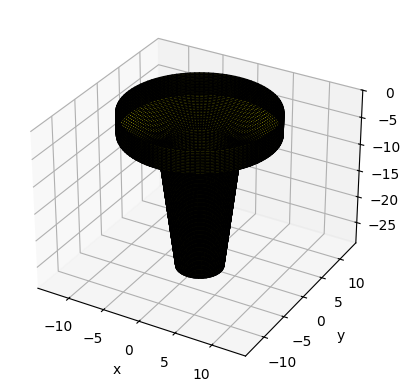

Panel Count:  9430
{'Heave': 900163.1779383643}
{'Heave': 128.92467058269582}
Solve Time (Radiation):  218.40202563500497
Solve Time (Diffraction):  0.22783926699776202
Excitation Phase:  -2.964891545956799


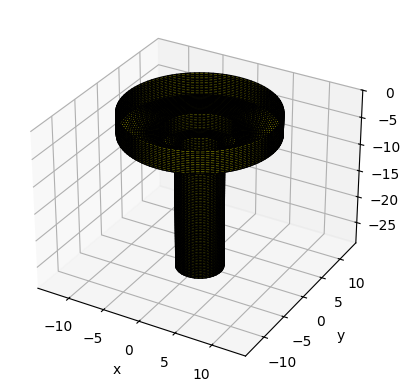

Panel Count:  7640
{'Heave': 1267775.601477086}
{'Heave': 201.84534596569247}
Solve Time (Radiation):  128.3742724659387
Solve Time (Diffraction):  0.10341393307317048
Excitation Phase:  -2.96546040849256


In [8]:
respack_slant = css.construct_and_solve(a, d_in, d_out, heaving, t_densities, face_units, h, m0, rho, reps)
respack_box = css.construct_and_solve(a, d, d, heaving, t_densities, face_units, h, m0, rho, reps)

In [8]:
# {'Heave': 1210179.7226987716}
# {'Heave': -103.98351909710485}
# {'Heave': 1440910.5022376822}
# {'Heave': -56.97661860657566}
# Added Mass: 171905.4456298079
# Damping: 10.085803874560884
# Added Mass (no slants): 1522929.08563564
# Damping (no slants): 79.37698682118173

In [9]:
def make_slant_region(d1, d2, a1, a2, res):
  a_prime = []
  d_prime = []
  d_in_prime = []
  d_out_prime = []
  delta_d = (d2 - d1)/res
  delta_a = (a2 - a1)/res
  offset = (delta_d < 0)
  for i in range(res):
     a_prime.append(a1 + (1 + i) * delta_a)
     d_prime.append(d1 + (offset + i) * delta_d)
     d_in_prime.append(d1 + i * delta_d)
     d_out_prime.append(d1 + (1 + i) * delta_d)
  return a_prime, d_prime, d_in_prime, d_out_prime


def slant_approx_vars(a, d_in, d_out, heaving, NMK, res):
  a_prime = []
  d_prime = []
  d_in_prime = []
  d_out_prime = []
  heaving_prime = []
  NMK_prime = []
  for i in range(len(a)):
    if d_in[i] == d_out[i]: # horizontal region
        a_prime.append(a[i])
        d_prime.append(d_in[i])
        d_in_prime.append(d_in[i])
        d_out_prime.append(d_in[i])
        heaving_prime.append(heaving[i])
        NMK_prime.append(NMK[i])
    else: # slanted region
       heaving_prime += ([heaving[i]] * res)
       NMK_prime += ([NMK[i]] * res)
       a_inner = 0 if i == 0 else a[i - 1]
       a_add, d_add, d_in_add, d_out_add = make_slant_region(d_in[i], d_out[i], a_inner, a[i], res)
       a_prime += a_add
       d_prime += d_add
       d_in_prime += d_in_add
       d_out_prime += d_out_add
  NMK_prime.append(NMK[-1])
  return a_prime, d_prime, d_in_prime, d_out_prime, heaving_prime, NMK_prime

In [10]:
a_prime, d_prime, d_in_prime, d_out_prime, heaving_prime, NMK_prime = slant_approx_vars(a, d_in, d_out, heaving, NMK, 1)

prob1, cs1, am1, dp1, bc1 = solve_MEEM(h, d_prime, a_prime, heaving_prime, NMK_prime, m0, rho)

slopes1 = get_slopes(bc1, d_in_prime, d_out_prime, a_prime)

ams1, dps1 = approximate_hydros(prob1, cs1, slopes1, d_out_prime)

print("Added Mass:", ams1)
print("Damping:", dps1)

print("Added Mass (no slants):", am1)
print("Damping (no slants):", dp1)


Added Mass: 538282.9857478971
Damping: 179.18260577019183
Added Mass (no slants): 1291734.6924434907
Damping (no slants): 182.8293817067148


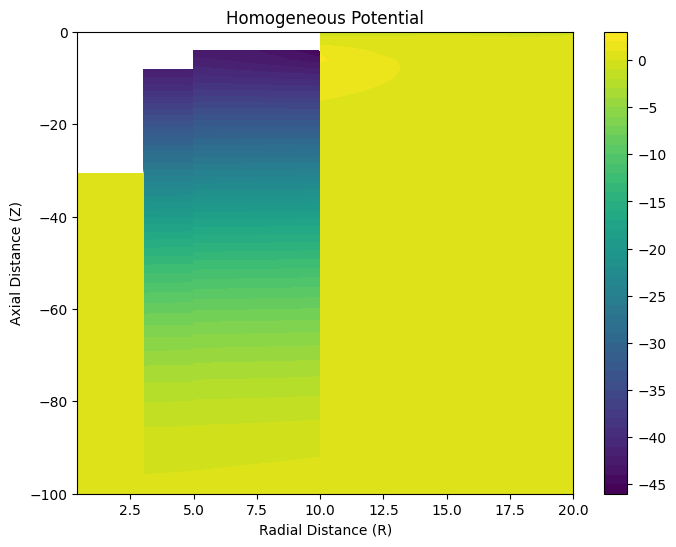

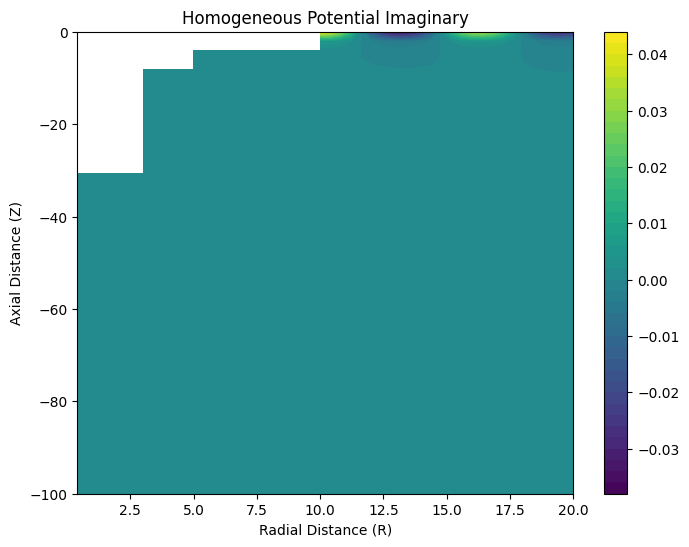

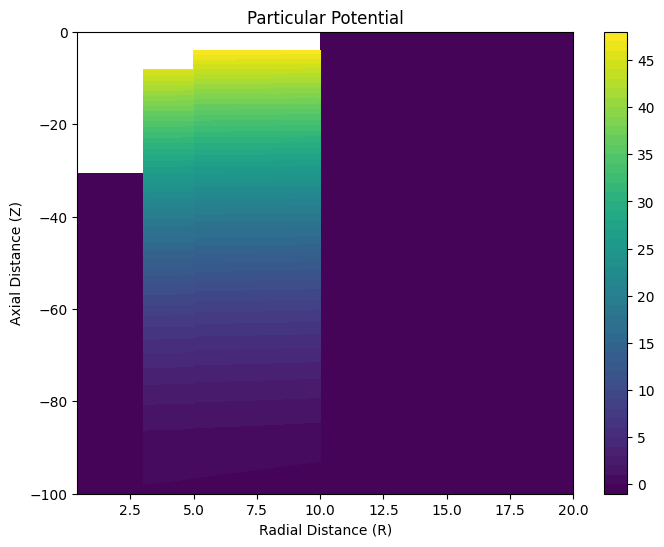

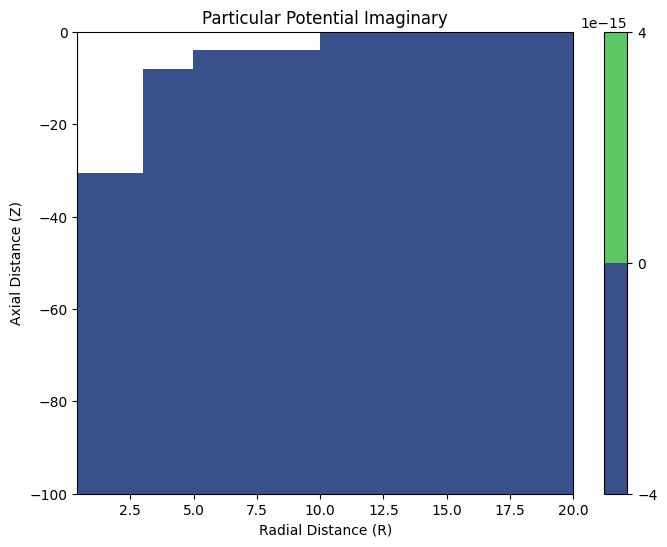

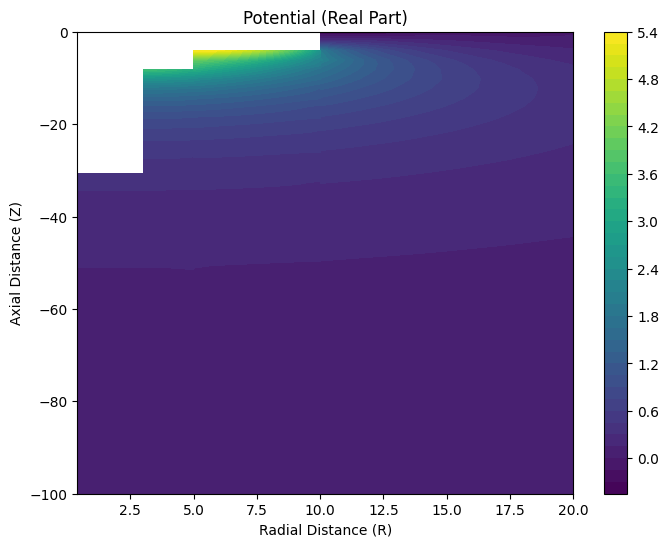

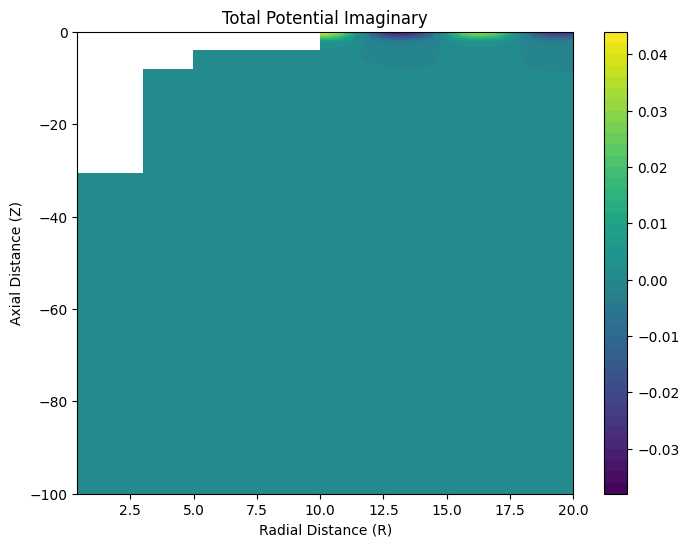

In [58]:
prob1.plot_potentials(cs1)

In [29]:
def integral_nonzero_slope_2(prob, region, cs, slopes, d_out):
  h, a, d, NMK = prob.h, prob.a, prob.d, prob.NMK

  def phi_h_n_inner_func(n, r, z):
      return (cs[0][n] * prob.R_1n(n, r, 0)) * prob.Z_n_i(n, z, 0)
  def phi_h_m_i_func(i, m, r, z):
      return (cs[i][m] * prob.R_1n(m, r, i) + cs[i][NMK[i] + m] * prob.R_2n(m, r, i)) * prob.Z_n_i(m, z, i)
  def phi_p_i(d, r, z): # particular solution
      return (1 / (2* (h - d))) * ((z + h) ** 2 - (r**2) / 2)
  
  terms = range(NMK[region])
  outer_rad = a[region]
  def z_wrt_r(r):
    return slopes[region] * (r - a[region]) - d_out[region]
  if region == 0:
    inner_rad = 0
    def integrand(r):
      t1 = sum([phi_h_n_inner_func(n, r, z_wrt_r(r)) for n in terms]) + phi_p_i(d[region], r, z_wrt_r(r))
      return t1 * r
  else:
    inner_rad = a[region - 1]
    def integrand(r):
      t1 = sum([phi_h_m_i_func(region, n, r, z_wrt_r(r)) for n in terms]) + phi_p_i(d[region], r, z_wrt_r(r))
      return t1 * r
  return integrate.quad(integrand, inner_rad, outer_rad, complex_func=True)[0]

def approximate_hydros_2(prob, cs, slopes, d_out):
    accumulator = 0
    for region in range(prob.boundary_count):
      if prob.heaving[region]:
        if slopes[region] == 0:
          accumulator += integral_zero_slope(prob, region, cs)
        else:
          accumulator += integral_nonzero_slope(prob, region, cs, slopes, d_out)

    base = 2 * pi * accumulator

    # Capytaine convention
    added_mass = base.real * prob.rho
    damping = base.imag * prob.angular_freq(prob.m0) * prob.rho

    return added_mass, damping

In [30]:
ams2, dps2 = approximate_hydros_2(prob1, cs1, slopes1, d_out_prime)

print(ams2, dps2)

805772.7916691118 99.2987571339877


In [52]:
def compute_all(a, d_in, d_out, heaving, NMK, m0, rho, res):
  a_prime, d_prime, d_in_prime, d_out_prime, heaving_prime, NMK_prime = slant_approx_vars(a, d_in, d_out, heaving, NMK, res)

  prob1, cs1, am1, dp1, bc1 = solve_MEEM(h, d_prime, a_prime, heaving_prime, NMK_prime, m0, rho)

  slopes1 = get_slopes(bc1, d_in_prime, d_out_prime, a_prime)

  ams1, dps1 = approximate_hydros(prob1, cs1, slopes1, d_out_prime)
  ams2, dps2 = approximate_hydros_2(prob1, cs1, slopes1, d_out_prime)
  
  return am1, dp1, ams1, dps1, ams2, dps2

In [53]:
output_accumulator = [[]] * 6
max_res = 35

def add_to_each(lst_of_lsts, lst):
  assert len(lst_of_lsts) == len(lst)
  for i in range(len(lst)):
    lst_of_lsts[i] = lst_of_lsts[i] + [lst[i]]

for res in range(1, max_res + 1):
  outputs = compute_all(a, d_in, d_out, heaving, NMK, m0, rho, res)
  add_to_each(output_accumulator, outputs)

am_boxes = output_accumulator[0]
am_style1 = output_accumulator[2]
am_style2 = output_accumulator[4]
dp_boxes = output_accumulator[1]
dp_style1 = output_accumulator[3]
dp_style2 = output_accumulator[5]
  

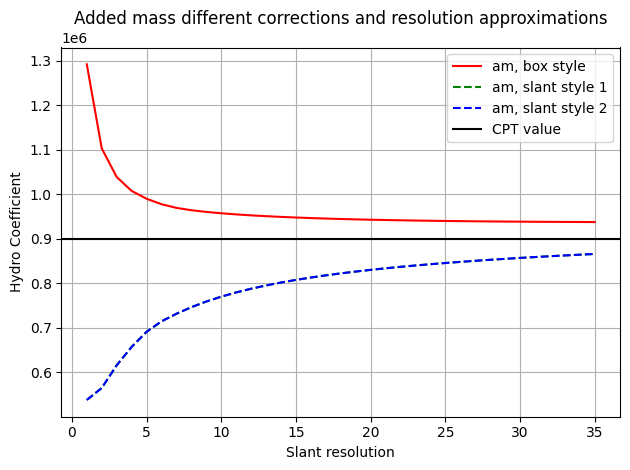

In [62]:
x = list(range(1, max_res + 1))

plt.plot(x, am_boxes, label='am, box style', color = "red")
plt.plot(x, am_style1, label='am, slant style 1', color = "green", linestyle = "--")
plt.plot(x, am_style2, label='am, slant style 2', color = "blue", linestyle = "--")
plt.axhline(y = (respack_slant[0].added_mass)["Heave"], color='black', linestyle='-', label = "CPT value")

# Labels and title
plt.xlabel('Slant resolution')
plt.ylabel('Hydro Coefficient')
plt.title('Added mass different corrections and resolution approximations')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [60]:
print((respack_slant[0].added_mass)["Heave"])

900163.1779383643


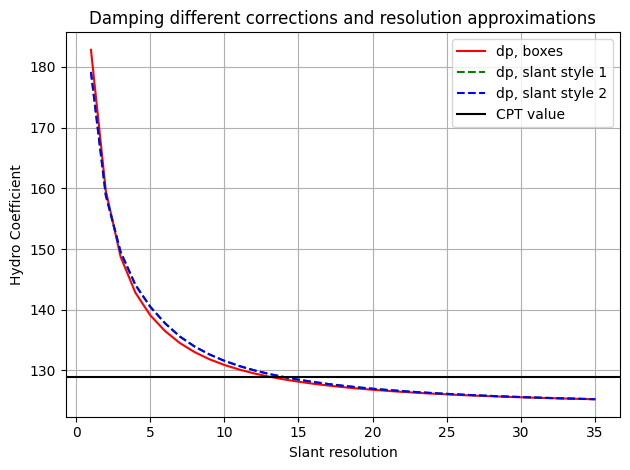

In [63]:
plt.plot(x, dp_boxes, label='dp, boxes', color = "red")
plt.plot(x, dp_style1, label='dp, slant style 1', color = "green", linestyle = "--")
plt.plot(x, dp_style2, label='dp, slant style 2', color = "blue", linestyle = "--")
plt.axhline(y = (respack_slant[0].radiation_damping)["Heave"], color='black', linestyle='-', label = "CPT value")


# Labels and title
plt.xlabel('Slant resolution')
plt.ylabel('Hydro Coefficient')
plt.title('Damping different corrections and resolution approximations')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Added Mass: 538282.9857478971
# Damping: 179.18260577019183
# Added Mass (no slants): 1291734.6924434907
# Damping (no slants): 182.8293817067148
# {'Heave': 900472.8655232441}
# {'Heave': 126.16624666101343}
# {'Heave': 1265138.658801795}
# {'Heave': 219.7201169852878}

In [ ]:
{'Heave': 900163.1779383643}
{'Heave': 128.92467058269582}

[538282.9857478971, 565052.9645337003, 615982.6923780179, 657249.358774249, 691131.577828394, 714653.0394543561, 731701.1370478147, 746477.1007091075, 759177.0687276594, 770104.8737381591, 779580.5192033924, 787892.4089639811, 795248.8278361083, 801811.5001728797, 807709.4660847966, 813046.3579372579, 817905.4722821547, 822354.1992555262, 826447.5734851286, 830230.9719692746, 833742.1445461094, 837012.7538253076, 840069.5569409853, 842935.3230704515, 845629.5533519675, 848169.0511013803, 850568.3773020058, 852840.2172739961, 854995.6779553444, 857044.5305302076, 858995.4096884395, 860855.9782306777, 862633.0638034324, 864332.7730834672, 865960.5876105931]
[538282.9857478971, 565052.9645337003, 615982.6923780179, 657249.358774249, 691131.577828394, 714653.0394543561, 731701.1370478147, 746477.1007091075, 759177.0687276594, 770104.8737381591, 779580.5192033924, 787892.4089639811, 795248.8278361083, 801811.5001728797, 807709.4660847966, 813046.3579372579, 817905.4722821547, 822354.1992555

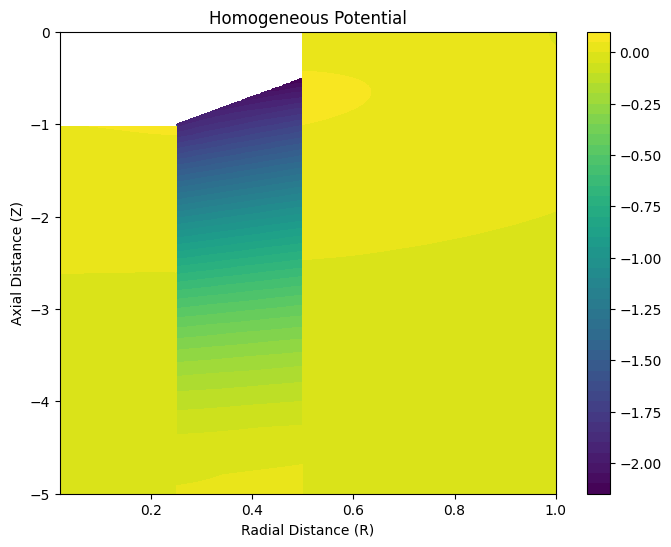

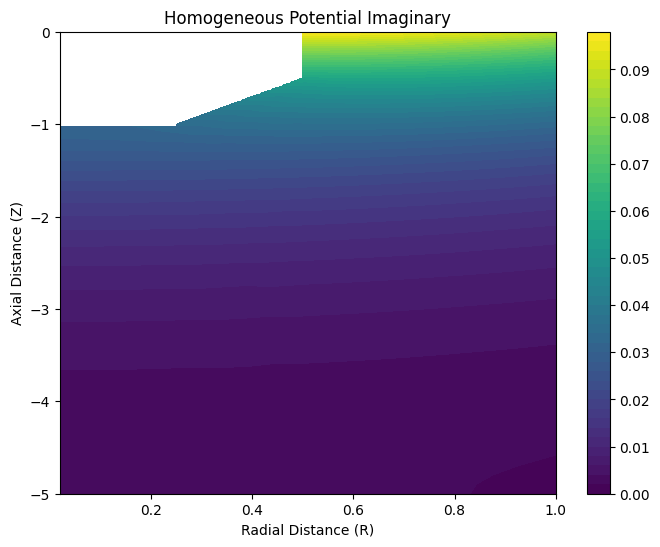

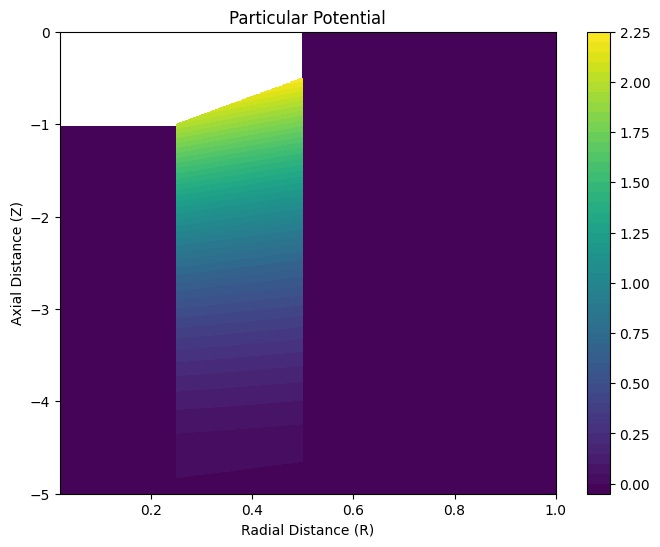

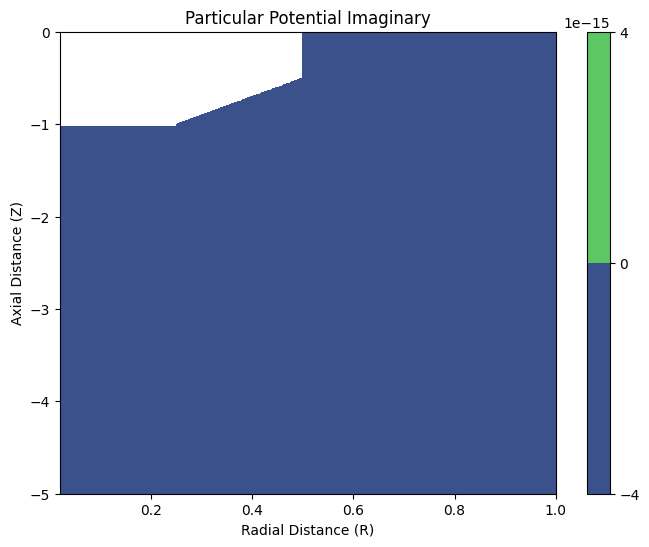

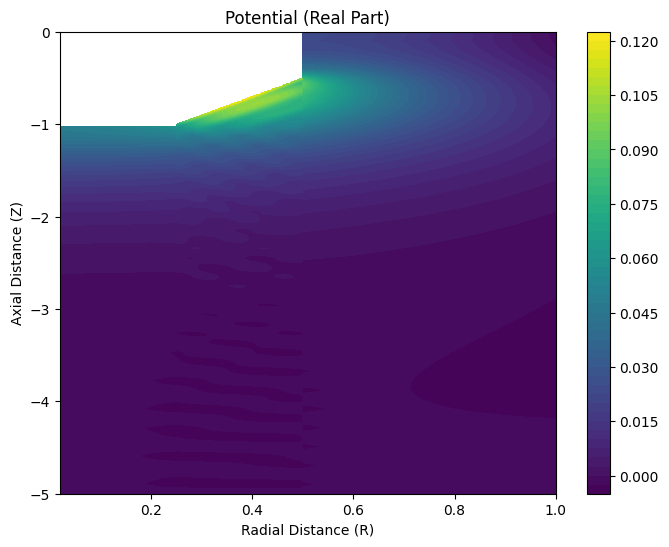

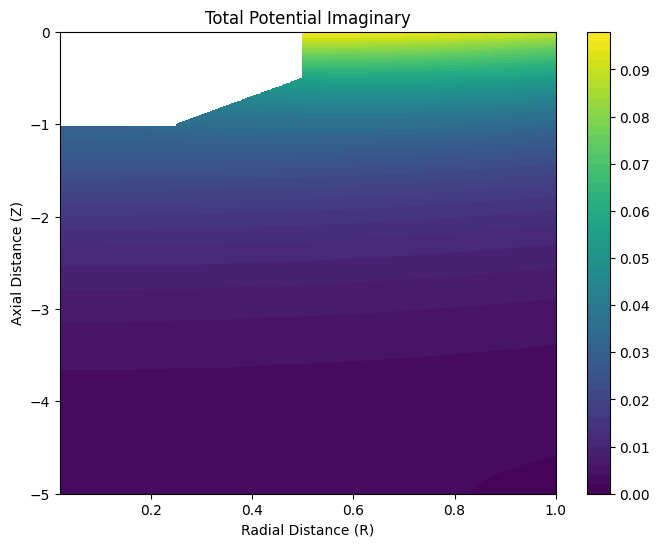

In [66]:
h = 5
d_in = [1, 1]
d_out = [1, 0.5]
a = [0.25, 0.5]
heaving = [0, 1]
NMK = [50, 50, 50]
m0 = 1
rho = 1023
a_prime, d_prime, d_in_prime, d_out_prime, heaving_prime, NMK_prime = slant_approx_vars(a, d_in, d_out, heaving, NMK, 80)
prob = Problem(h, d_prime, a_prime, heaving_prime, NMK_prime, m0, rho)
a_matrix = prob.a_matrix()
b_vector = prob.b_vector()
x = prob.get_unknown_coeffs(a_matrix, b_vector)
cs = prob.reformat_coeffs(x)
am, dp = prob.hydro_coeffs(x, "capytaine")
prob.plot_potentials(cs)